In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#from fastaiold.structured import *

In [3]:
import numpy as np
import pandas as pd
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from scipy.stats import norm, skew

import math
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

#from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

import string
import warnings
warnings.filterwarnings('ignore')

In [4]:
PATH = "../../../data/house_pricing/"

In [5]:
df_train=pd.read_csv(f'{PATH}train.csv')#, index_col='Id')
df_test=pd.read_csv(f'{PATH}test.csv')#, index_col='Id')

### Y (target value) to Log, as stated at Kaggle Evaluation page

In [6]:
# for the purpose of evaluation of current competition
#df_train.SalePrice = np.log1p(df_train.SalePrice)
df_train.SalePrice = np.log1p(df_train.SalePrice)

In [7]:
print('Number of Training Examples = {}'.format(df_train.shape[0]))
print('Number of Test Examples = {}\n'.format(df_test.shape[0]))
print('Training X Shape = {}'.format(df_train.shape))
print('Training y Shape = {}\n'.format(df_train['SalePrice'].shape[0]))
print('Test X Shape = {}'.format(df_test.shape))
print('Test y Shape = {}\n'.format(df_test.shape[0]))
#print(df_train.columns)
#print(df_test.columns)

Number of Training Examples = 1460
Number of Test Examples = 1459

Training X Shape = (1460, 81)
Training y Shape = 1460

Test X Shape = (1459, 80)
Test y Shape = 1459



In [8]:
#print(df_train.info())
#df_train.sample(3)
#print(df_test.info())
#df_test.sample(3)

# Dealing with Outliers

Text(0.5, 0, 'GrLivArea')

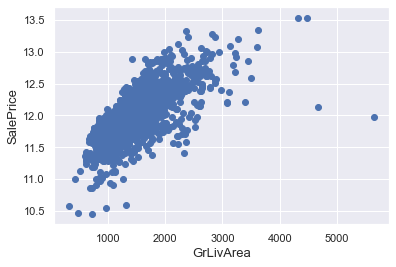

In [9]:
fig, ax = plt.subplots()
ax.scatter(x = df_train['GrLivArea'], y = df_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
#plt.show()

### -> To delete outliers

Text(0.5, 0, 'GrLivArea')

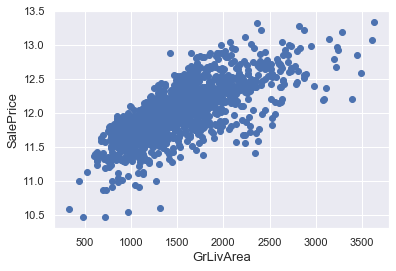

In [10]:
# Deleting outliers
df_train = df_train.drop(df_train[(df_train['GrLivArea']>4000) & (df_train['SalePrice']<300000)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(df_train['GrLivArea'], df_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
#plt.show()

In [11]:
#Correlations with Target value

# Features engineering

In [12]:
#check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(df_train.shape))
print("The test data size before dropping Id feature is : {} ".format(df_test.shape))

#Save the 'Id' column
train_ID = df_train['Id']
test_ID = df_test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
df_train.drop("Id", axis = 1, inplace = True)
df_test.drop("Id", axis = 1, inplace = True)

#check again the data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(df_train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(df_test.shape))


The train data size before dropping Id feature is : (1456, 81) 
The test data size before dropping Id feature is : (1459, 80) 

The train data size after dropping Id feature is : (1456, 80) 
The test data size after dropping Id feature is : (1459, 79) 


## Correlation

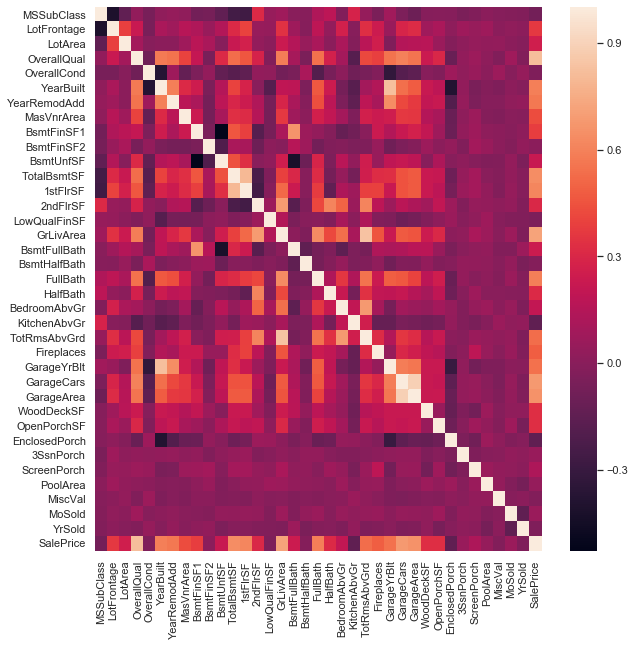

In [13]:
plt.figure(figsize=(10, 10))
sns.heatmap(df_train.corr())
#plt.plot()

In [14]:
"""
fig, axs = plt.subplots(nrows=2, figsize=(20, 20))

sns.heatmap(df_train.corr(), ax=axs[0], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})
sns.heatmap(df_test.corr(), ax=axs[1], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})

for i in range(2):    
    axs[i].tick_params(axis='x', labelsize=14)
    axs[i].tick_params(axis='y', labelsize=14)
    
axs[0].set_title('Training Set Correlations', size=15)
axs[1].set_title('Test Set Correlations', size=15)

plt.show()
"""

"\nfig, axs = plt.subplots(nrows=2, figsize=(20, 20))\n\nsns.heatmap(df_train.corr(), ax=axs[0], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})\nsns.heatmap(df_test.corr(), ax=axs[1], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})\n\nfor i in range(2):    \n    axs[i].tick_params(axis='x', labelsize=14)\n    axs[i].tick_params(axis='y', labelsize=14)\n    \naxs[0].set_title('Training Set Correlations', size=15)\naxs[1].set_title('Test Set Correlations', size=15)\n\nplt.show()\n"

In [15]:
"""
df_corr=df_train.corr().sort_values(kind="quicksort", ascending=False, by='SalePrice').abs()
df_corr.drop(axis=1, columns=df_corr.columns.drop('SalePrice'), inplace=True)
df_corr
"""

'\ndf_corr=df_train.corr().sort_values(kind="quicksort", ascending=False, by=\'SalePrice\').abs()\ndf_corr.drop(axis=1, columns=df_corr.columns.drop(\'SalePrice\'), inplace=True)\ndf_corr\n'

# Dealing with Missing Values

In [16]:
def concat_df(train_data, test_data):
    # Returns a concatenated df of training and test set on axis 0
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

df_all = concat_df(df_train, df_test)

df_train.name = 'Training Set'
df_test.name = 'Test Set'
df_all.name = 'All Set' 

dfs = [df_train, df_test]

df_all.shape

(2915, 80)

In [17]:
#remember where to divide train and test
ntrain = df_train.shape[0]
ntest = df_test.shape[0]

In [18]:
#Dividing Target column (Y)
y_train_full = df_train.SalePrice.values
df_all.drop(['SalePrice'], axis=1, inplace=True)

In [24]:
def display_missing(df):
    for col in df.columns:
        print(col, df[col].isnull().sum())
    print('\n')
    
for df in dfs:
    print(format(df.name))
    display_missing(df)
    
    
    
#Check remaining missing values if any 
def display_only_missing(df):
    all_data_na = (df.isnull().sum() / len(df)) * 100
    all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
    missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
    print(missing_data.head())

Training Set
MSSubClass 0
MSZoning 0
LotFrontage 259
LotArea 0
Street 0
Alley 1365
LotShape 0
LandContour 0
Utilities 0
LotConfig 0
LandSlope 0
Neighborhood 0
Condition1 0
Condition2 0
BldgType 0
HouseStyle 0
OverallQual 0
OverallCond 0
YearBuilt 0
YearRemodAdd 0
RoofStyle 0
RoofMatl 0
Exterior1st 0
Exterior2nd 0
MasVnrType 8
MasVnrArea 8
ExterQual 0
ExterCond 0
Foundation 0
BsmtQual 37
BsmtCond 37
BsmtExposure 38
BsmtFinType1 37
BsmtFinSF1 0
BsmtFinType2 38
BsmtFinSF2 0
BsmtUnfSF 0
TotalBsmtSF 0
Heating 0
HeatingQC 0
CentralAir 0
Electrical 1
1stFlrSF 0
2ndFlrSF 0
LowQualFinSF 0
GrLivArea 0
BsmtFullBath 0
BsmtHalfBath 0
FullBath 0
HalfBath 0
BedroomAbvGr 0
KitchenAbvGr 0
KitchenQual 0
TotRmsAbvGrd 0
Functional 0
Fireplaces 0
FireplaceQu 690
GarageType 81
GarageYrBlt 81
GarageFinish 81
GarageCars 0
GarageArea 0
GarageQual 81
GarageCond 81
PavedDrive 0
WoodDeckSF 0
OpenPorchSF 0
EnclosedPorch 0
3SsnPorch 0
ScreenPorch 0
PoolArea 0
PoolQC 1451
Fence 1176
MiscFeature 1402
MiscVal 0
MoSold

In [25]:
"""# change NA values in test set - to median
def nan_to_mean(df):
    for col in df.columns:
        if is_numeric_dtype(col):
            df[col].fillna(value=df[col].median(), inplace=True)
            print(col, df[col].median())
            
#nan_to_mean(df_all)
"""

'# change NA values in test set - to median\ndef nan_to_mean(df):\n    for col in df.columns:\n        if is_numeric_dtype(col):\n            df[col].fillna(value=df[col].median(), inplace=True)\n            print(col, df[col].median())\n            \n#nan_to_mean(df_all)\n'

In [26]:
# fill value with None - based on data description -  - for non-Numerical (object) Columns
for col in ('PoolQC','MiscFeature','Alley','Fence','FireplaceQu','GarageType', 'GarageFinish', 'GarageQual', 'GarageCond','BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType','MSSubClass'):
    df_all[col] = df_all[col].fillna('None')
    
#fill value with '0' - based on data description - for Numerical Columns
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars','BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath','MasVnrArea'):
    df_all[col] = df_all[col].fillna(0)
    
    
### To consider: remove 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF'

In [27]:
df_all['Utilities'].mode()[0]

'AllPub'

In [28]:
display_only_missing(df_all)

             Missing Ratio
LotFrontage      16.672384
MSZoning          0.137221
Utilities         0.068611
Functional        0.068611
SaleType          0.034305


In [29]:
"""
# !for the begining I use just median of whole Dataset!

### -> in future try to use grouped median by neighborhood
LotFrontage : Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can fill in missing values by the median LotFrontage of the neighborhood.
"""
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
df_all["LotFrontage"] = df_all.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))


#df_all['LotFrontage'].fillna(value=df_all['LotFrontage'].median(), inplace=True)


In [30]:
df_all['LotFrontage']

0        65.0
1        80.0
2        68.0
3        60.0
4        84.0
        ...  
2910     21.0
2911     21.0
2912    160.0
2913     62.0
2914     74.0
Name: LotFrontage, Length: 2915, dtype: float64

In [31]:
display_only_missing(df_all)

             Missing Ratio
MSZoning          0.137221
Utilities         0.068611
Functional        0.068611
SaleType          0.034305
KitchenQual       0.034305


In [32]:
# find most frequent value for MSZoning
df_all.MSZoning.mode()

0    RL
dtype: object

In [33]:
#!!!!!!


In [34]:
# Fill missing value in corresponding columns with most frequent value in column
#for col in ('MSZoning','Electrical','KitchenQual','Exterior1st','Exterior2nd','SaleType','Utilities'):
#    df_all[col].fillna(df_all[col].mode()[0], inplace=True)

In [35]:
#!!!!!!


In [36]:
# Utilities : For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA . Since the house with 'NoSewa' is in the training set, \
# this feature won't help in predictive modelling. We can then safely remove it.

#df_all = df_all.drop(['Utilities'], axis=1)


In [37]:
display_only_missing(df_all)

             Missing Ratio
MSZoning          0.137221
Utilities         0.068611
Functional        0.068611
SaleType          0.034305
KitchenQual       0.034305


In [38]:
df_all.Functional.mode()

0    Typ
dtype: object

In [39]:
# Functional : data description says NA means typical
# BTW we can just use df_all.Functional.mode() = use most frequent value (as 'Typ' is most frequent value)
df_all["Functional"] = df_all["Functional"].fillna("Typ")

In [40]:
display_only_missing(df_all)

             Missing Ratio
MSZoning          0.137221
Utilities         0.068611
SaleType          0.034305
KitchenQual       0.034305
Exterior2nd       0.034305


In [41]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2915 entries, 0 to 2914
Data columns (total 79 columns):
1stFlrSF         2915 non-null int64
2ndFlrSF         2915 non-null int64
3SsnPorch        2915 non-null int64
Alley            2915 non-null object
BedroomAbvGr     2915 non-null int64
BldgType         2915 non-null object
BsmtCond         2915 non-null object
BsmtExposure     2915 non-null object
BsmtFinSF1       2915 non-null float64
BsmtFinSF2       2915 non-null float64
BsmtFinType1     2915 non-null object
BsmtFinType2     2915 non-null object
BsmtFullBath     2915 non-null float64
BsmtHalfBath     2915 non-null float64
BsmtQual         2915 non-null object
BsmtUnfSF        2915 non-null float64
CentralAir       2915 non-null object
Condition1       2915 non-null object
Condition2       2915 non-null object
Electrical       2914 non-null object
EnclosedPorch    2915 non-null int64
ExterCond        2915 non-null object
ExterQual        2915 non-null object
Exterior1st      29

### Seems no missed values
Missing Values = DONE

# Scewed data

In [42]:
"""numeric_feats = df_all.dtypes[df_all.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = df_all[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)
"""

'numeric_feats = df_all.dtypes[df_all.dtypes != "object"].index\n\n# Check the skew of all numerical features\nskewed_feats = df_all[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)\nprint("\nSkew in numerical features: \n")\nskewness = pd.DataFrame({\'Skew\' :skewed_feats})\nskewness.head(10)\n'

In [43]:
"""
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    df_all[feat] = boxcox1p(df_all[feat], lam)
"""

'\nskewness = skewness[abs(skewness) > 0.75]\nprint("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))\n\nfrom scipy.special import boxcox1p\nskewed_features = skewness.index\nlam = 0.15\nfor feat in skewed_features:\n    #all_data[feat] += 1\n    df_all[feat] = boxcox1p(df_all[feat], lam)\n'

# Normalization

In [44]:
#Normalization, the Sigmoid, Log, Cube Root and the Hyperbolic Tangent. 
#It all depends on what one is trying to accomplish.

In [45]:
#df_all.info()

# Features generation

In [46]:
df_all['TotalSF'] = df_all['TotalBsmtSF'] + df_all['1stFlrSF'] + df_all['2ndFlrSF']

# Dealing with categorical values

In [47]:
def show_object_columns(df):
    for col in df:
        if is_string_dtype(df[col]):
            print(col)
show_object_columns(df_all)

Alley
BldgType
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
BsmtQual
CentralAir
Condition1
Condition2
Electrical
ExterCond
ExterQual
Exterior1st
Exterior2nd
Fence
FireplaceQu
Foundation
Functional
GarageCond
GarageFinish
GarageQual
GarageType
Heating
HeatingQC
HouseStyle
KitchenQual
LandContour
LandSlope
LotConfig
LotShape
MSZoning
MasVnrType
MiscFeature
Neighborhood
PavedDrive
PoolQC
RoofMatl
RoofStyle
SaleCondition
SaleType
Street
Utilities


In [48]:
# Transforming some numerical variables that are really categorical

# MSSubClass=The building class
#df_all['MSSubClass'] = df_all['MSSubClass'].astype(str)


# Changing OverallCond into a categorical variable
#df_all['OverallCond'] = df_all['OverallCond'].astype(str)


# Year and month sold are transformed into categorical features.
#df_all['YrSold'] = df_all['YrSold'].astype(str)
#df_all['MoSold'] = df_all['MoSold'].astype(str)

In [49]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2915 entries, 0 to 2914
Data columns (total 80 columns):
1stFlrSF         2915 non-null int64
2ndFlrSF         2915 non-null int64
3SsnPorch        2915 non-null int64
Alley            2915 non-null object
BedroomAbvGr     2915 non-null int64
BldgType         2915 non-null object
BsmtCond         2915 non-null object
BsmtExposure     2915 non-null object
BsmtFinSF1       2915 non-null float64
BsmtFinSF2       2915 non-null float64
BsmtFinType1     2915 non-null object
BsmtFinType2     2915 non-null object
BsmtFullBath     2915 non-null float64
BsmtHalfBath     2915 non-null float64
BsmtQual         2915 non-null object
BsmtUnfSF        2915 non-null float64
CentralAir       2915 non-null object
Condition1       2915 non-null object
Condition2       2915 non-null object
Electrical       2914 non-null object
EnclosedPorch    2915 non-null int64
ExterCond        2915 non-null object
ExterQual        2915 non-null object
Exterior1st      29

In [50]:
def unique_categories(df,n=10000):
    """
    Print only categorical columns Names and Number of unique values in corresponding column 
    df - DataFrame
    n - show only columns with less then N unique values, 
        as default - not show column if more than 10000 unique value - not pseudo categorical
    """
    for col in df:
        if is_categorical_dtype(df[col]):
            if sum(np.unique(df[col].cat.categories,return_counts=True)[1])<n:
                print(col, sum(np.unique(df[col].cat.categories,return_counts=True)[1]))

In [51]:
unique_categories(df_all)

In [52]:
# convert object columns to categorical
def conv_obj_to_categories(df):
    """
    Convert Object columns to Categorical
    """
    for col in df:
        if is_string_dtype(df[col]):
            df[col]=df[col].astype('category')


In [53]:



#conv_obj_to_categories(df_all)






In [54]:
def show_categorical_columns(df):
    """
    Print only categorical columns Number, Name and Codes of unique values in corresponding column 
    """
    for col in df:
        if is_categorical_dtype(df[col]):
            print(sum(np.unique(df[col].cat.categories,return_counts=True)[1]), col ,df[col].cat.categories)

In [55]:
show_categorical_columns(df_all)

## Check numeric columns (if they are actually Categorical, like Year)

### Experimenting - heavily convert NUMERICAL to CATEGORICAL

In [56]:
df_allcats=df_all.copy()

In [57]:
### Experimenting with Numerical Categories
def conv_num_cat (df):
    for col in df:
        if is_numeric_dtype(df[col]): 
            df[col]=df[col].astype('category')
        else:
            df.drop(columns=col, inplace=True)

In [58]:
conv_num_cat(df_allcats)

In [59]:
unique_categories(df_allcats,20)

BedroomAbvGr 8
BsmtFullBath 4
BsmtHalfBath 3
Fireplaces 5
FullBath 5
GarageCars 6
HalfBath 3
KitchenAbvGr 4
MSSubClass 16
MoSold 12
OverallCond 9
OverallQual 10
PoolArea 12
TotRmsAbvGrd 14
YrSold 5


In [60]:
#conv_to_cat_longlist=['BedroomAbvGr', 'BsmtFullBath','BsmtHalfBath', 'Fireplaces', 'FullBath',\
#             'GarageCars','HalfBath','KitchenAbvGr','MSSubClass','MoSold','OverallCond',\
#             'OverallQual','PoolArea','TotRmsAbvGrd','YrSold']

In [61]:
conv_to_cat_shortlist=['HalfBath','MSSubClass', 'MoSold','OverallCond', 'OverallQual','YrSold']

In [62]:
#for cat in conv_to_cat_longlist:
#    df_all[cat]=df_all[cat].astype('category')

for cat in conv_to_cat_shortlist:
    df_all[cat]=df_all[cat].astype('category')

In [63]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2915 entries, 0 to 2914
Data columns (total 80 columns):
1stFlrSF         2915 non-null int64
2ndFlrSF         2915 non-null int64
3SsnPorch        2915 non-null int64
Alley            2915 non-null object
BedroomAbvGr     2915 non-null int64
BldgType         2915 non-null object
BsmtCond         2915 non-null object
BsmtExposure     2915 non-null object
BsmtFinSF1       2915 non-null float64
BsmtFinSF2       2915 non-null float64
BsmtFinType1     2915 non-null object
BsmtFinType2     2915 non-null object
BsmtFullBath     2915 non-null float64
BsmtHalfBath     2915 non-null float64
BsmtQual         2915 non-null object
BsmtUnfSF        2915 non-null float64
CentralAir       2915 non-null object
Condition1       2915 non-null object
Condition2       2915 non-null object
Electrical       2914 non-null object
EnclosedPorch    2915 non-null int64
ExterCond        2915 non-null object
ExterQual        2915 non-null object
Exterior1st      29

# Label Encoding

In [64]:
"""from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(df_all[c].values)) 
    df_all[c] = lbl.transform(list(df_all[c].values))
    """

"from sklearn.preprocessing import LabelEncoder\ncols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', \n        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', \n        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',\n        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', \n        'YrSold', 'MoSold')\n# process columns, apply LabelEncoder to categorical features\nfor c in cols:\n    lbl = LabelEncoder() \n    lbl.fit(list(df_all[c].values)) \n    df_all[c] = lbl.transform(list(df_all[c].values))\n    "

# Dummies

In [65]:
df_all=pd.get_dummies(df_all)

# Making Training, Validation, Test Dataset

In [66]:
"""Dividing working DataFrame back to Train and Test"""
# split Validational/Test set from Training set after Categorical Value Engeneering
X_test=df_all.iloc[ntrain:] # Test set
X_train_full=df_all.iloc[:ntrain] # Train set

In [67]:
df.shape, y_train_full.shape, X_test.shape, X_train_full.shape

((1459, 79), (1456,), (1459, 351), (1456, 351))

In [68]:
from sklearn.model_selection import train_test_split

In [69]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full)

In [70]:
X_train.shape, X_valid.shape

((1092, 351), (364, 351))

# Machine Learning

## Evaluation

In [71]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [72]:
# Evaluation of simple Random Forest
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 410 ms, sys: 7.54 ms, total: 417 ms
Wall time: 269 ms
[0.06182576220090753, 0.16639680176767926, 0.9756112319998967, 0.8234779264550331]


In [73]:
from sklearn.metrics import mean_squared_error

In [74]:

math.sqrt(mean_squared_error(y_valid, m.predict(X_valid)))

0.16639680176767932

In [75]:
# if you need to evaluate LOG Root mean squared error but wouldn't like to convert y to log(y)

In [76]:
from sklearn.metrics import mean_squared_log_error

In [77]:
math.sqrt(mean_squared_log_error(np.expm1(y_valid), np.expm1(m.predict(X_valid))))

0.16639680176767938

### Experimenting with Random Forest

In [78]:
m_rf = RandomForestRegressor(n_estimators=160, min_samples_leaf=1, max_features=0.5, n_jobs=-1, oob_score=True)
m_rf.fit(X_train, y_train)
print_score(m_rf)

[0.047982066163442694, 0.15340445726325913, 0.9853104397550386, 0.8499676098692402, 0.8911539641477477]


### XGBoost

In [79]:
from xgboost import XGBRegressor

In [80]:
m_xgb = XGBRegressor(n_estimators=1000, learning_rate=0.05)
# using early_stop to find out where validation scores don't improve
m_xgb.fit(X_train, y_train, early_stopping_rounds=5, eval_set=[(X_valid, y_valid)], verbose=False)
%time m_xgb.fit(X_train, y_train)
print_score(m_xgb)

[14:43:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:43:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 18.6 s, sys: 87.8 ms, total: 18.7 s
Wall time: 19.6 s
[0.06852225459719845, 0.138588448195398, 0.9700419050752164, 0.87754877482306]


### GBDT (Gradient Boosting Decision Tree)

In [81]:
from sklearn.ensemble import GradientBoostingRegressor

In [82]:
m_gbdt=GradientBoostingRegressor(n_estimators=1000, learning_rate=0.05)
%time m_gbdt.fit(X_train, y_train)
print_score(m_gbdt)

CPU times: user 8.64 s, sys: 46.9 ms, total: 8.68 s
Wall time: 9.03 s
[0.031037045279147808, 0.1322299357683444, 0.9938537298685859, 0.8885272680329541]


# Feature Importance

In [83]:
fi = pd.DataFrame({'feature': list(X_train.columns), 'importance':m_rf.feature_importances_}).sort_values('importance',ascending=False)

In [84]:
fi[:50]

,feature,importance
30,TotalSF,0.393372
15,GrLivArea,0.108469
28,YearBuilt,0.086569
100,ExterQual_TA,0.081133
13,GarageCars,0.025064
12,GarageArea,0.023737
26,TotalBsmtSF,0.018107
0,1stFlrSF,0.017830
29,YearRemodAdd,0.017508
17,LotArea,0.013664


In [85]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((1092, 351), (364, 351), (1092,), (364,))

In [85]:
def find_features_to_drop(X_train, X_valid, y_train, y_valid):
    """ Using RandomForest identifies important feature 
    and one by one drop least important features from DataFrame to improve model score
    input - X_train, X_valid, y_train, y_valid, same as used in training and evaluation model using train/valid split
    """
    m_feature_to_drop = RandomForestRegressor(n_estimators=160, min_samples_leaf=1, max_features=0.5, n_jobs=-1, oob_score=False)
    # to try - not use actual feature importance each iteration, but use only first one
    #        m_feature_to_drop.fit(X_train, y_train)
    #        fi = pd.DataFrame({'feature': list(X_train.columns), 'importance':m_feature_to_drop.feature_importances_}).sort_values('importance',ascending=False)
    
    # Number of features in DataFrame
    num_of_features=X_train.shape[1]
    
    list_of_original_columns=X_train.columns
    
    best_grade=1
    list_of_feature_to_drop=pd.DataFrame()
    #grades={}
    
    for iteration in range(0, num_of_features):
            
        # Iteratively fit model with features without 1 least important (dropped in previos iteration)
        m_feature_to_drop.fit(X_train, y_train)
        # Evaluating performance withot this feature
        grade=math.sqrt(mean_squared_error(y_valid, m_feature_to_drop.predict(X_valid)))

        # Updating based on new model list of feature importance
        fi = pd.DataFrame({'feature': list(X_train.columns), 'importance':m_feature_to_drop.feature_importances_}).sort_values('importance',ascending=False)

        # Finding best score
        if grade<best_grade:
            best_grade=grade
            best_num_of_features=(num_of_features-iteration)
            list_of_feature_to_drop=list_of_original_columns.difference(fi.feature)

        # Dropping last 1 (least important feature)
        X_train=X_train.drop(columns=fi.feature[-1:])
        X_valid=X_valid.drop(columns=fi.feature[-1:])

        print ((num_of_features-iteration),grade, fi.feature[-1:])
        #grades.update({(num_of_features-iteration):grade})
    print(best_grade,best_num_of_features) 
    return list_of_feature_to_drop

In [86]:
#features_to_drop=find_features_to_drop(X_train, X_valid, y_train, y_valid)

In [87]:
features_to_drop
#fi.feature==fi.feature

NameError: name 'features_to_drop' is not defined

In [ ]:
x=list(grades.keys())
y=list(grades.values())

ax = plt.axes()
plt.plot(x,y)
plt.show()

In [ ]:

ax = plt.axes()
plt.xlim(150,300)
plt.ylim(0.133,0.1350)
plt.plot(x,y)
plt.show()

In [104]:
df_all.shape

(2915, 233)

In [127]:
#df_all=df_all.drop(columns=features_to_drop)
#df_all=df_all.drop(columns=fi.feature[150:])

In [108]:
"""Dividing working DataFrame back to Train and Test"""
# split Validational/Test set from Training set after Categorical Value Engeneering
X_test=df_all.iloc[ntrain:] # Test set
X_train_full=df_all.iloc[:ntrain] # Train set
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full)


In [109]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((1092, 150), (364, 150), (1092,), (364,))

# Stacking

In [ ]:
preds_rf=m_rf.predict(X_valid)
preds_xgb=m_xgb.predict(X_valid)
preds_gbdt=m_gbdt.predict(X_valid)

test_preds_rf=m_rf.predict(X_test)
test_preds_xgb=m_xgb.predict(X_test)
test_preds_gbdt=m_gbdt.predict(X_test)

In [ ]:
stacked_predictions=np.column_stack((preds_rf,preds_xgb,preds_gbdt))
stacked_test_predictions=np.column_stack((test_preds_rf,test_preds_xgb,test_preds_gbdt))

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
meta_model=LinearRegression()

stacked_predictions

In [ ]:
stacked_predictions.shape

In [ ]:
meta_model.fit(stacked_predictions,y_valid)

In [ ]:
# testing of very simple stacking
y_pred = np.expm1(meta_model.predict(stacked_test_predictions))

In [ ]:
y_pred

# Testing stacking from Kaggle

In [110]:
from sklearn.base import BaseEstimator
from sklearn.base import RegressorMixin
from sklearn.base import TransformerMixin,clone

In [111]:
from sklearn.model_selection import KFold, cross_val_score
n_folds=2
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train_full.values)
    rmse= np.sqrt(-cross_val_score(model, X_train_full.values, y_train_full, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [112]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1231 (0.0081)



In [113]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import ElasticNet, Lasso

lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))


In [114]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1196 (0.0071)



In [78]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

NameError: name 'rmsle_cv' is not defined

In [116]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [117]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, lasso),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1132 (0.0062)


In [118]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [119]:
stacked_averaged_models.fit(X_train_full.values, y_train_full)
stacked_train_pred = stacked_averaged_models.predict(X_train_full.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(X_test.values))
print(rmsle(y_train_full, stacked_train_pred))

0.0772362623843651


In [120]:
m_xgb.fit(X_train_full, y_train_full)
xgb_train_pred = m_xgb.predict(X_train_full)
xgb_pred = np.expm1(m_xgb.predict(X_test))
print(rmsle(y_train_full, xgb_train_pred))

[19:53:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.0693001092295417


In [121]:
m_rf.fit(X_train_full, y_train_full)
rf_train_pred = m_rf.predict(X_train_full)
rf_pred = np.expm1(m_rf.predict(X_test.values))
print(rmsle(y_train_full, rf_train_pred))

0.0490352209533211


In [122]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y_train_full,stacked_train_pred*0.7 +
               xgb_train_pred*0.15+rf_train_pred*0.15))

RMSLE score on train data:
0.06864152011593704


In [123]:
y_pred = stacked_pred*0.7 +xgb_pred*0.15+rf_pred*0.15

In [124]:
y_pred

array([121003.33917858, 153554.40691275, 191136.28468551, ...,
       160524.13507654, 115819.16980192, 221697.31919093])

# Predictions for submission

### Random Forest

In [ ]:
# Training model on full data from Training Data Set
m_final_rf = RandomForestRegressor(n_estimators=160, min_samples_leaf=1, max_features=0.5, n_jobs=-1, oob_score=True)
m_final_rf.fit(X_train_full, y_train_full)

In [ ]:
# Remove all ,[] symbols from dataframe columns and values
#X_valid_testset.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_valid_testset.columns.values]

### XGBoost

In [90]:
m_final_xgb = XGBRegressor(n_estimators=2000, learning_rate=0.05)
m_final_xgb.fit(X_train_full, y_train_full)

[17:00:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=2000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

## Gradient Boosting Decision Tree

In [108]:
X_train_full.shape, y_train_full.shape

((1456, 351), (1456,))

In [339]:
m_final_gbdt=GradientBoostingRegressor(n_estimators=2000, learning_rate=0.05)
m_final_gbdt.fit(X_train_full, y_train_full)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.05, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=2000,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

## Predicting

In [92]:
y_pred = np.expm1(m_final_xgb.predict(X_test))

In [93]:
y_pred

array([125723.34 , 160317.94 , 209049.86 , ..., 160801.66 , 115436.945,
       220957.44 ], dtype=float32)

# Submission

In [125]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = y_pred
sub.to_csv('submission_14Aug19.csv',index=False)

In [126]:
sub.head()

,Id,SalePrice
0,1461,121003.339179
1,1462,153554.406913
2,1463,191136.284686
3,1464,197262.891606
4,1465,190588.917279
